MSc Project

This aim of this project is to find insights into socio-demographic and economic factors that matter to life satisfaction, the main research question is, What matters most to peoples life satisfaction. The data used in this project is from the UK Data Archive and its a Annual Population Survey Three-Year Pooled Dataset, January 2021 - December 2023.

In [3]:
import pandas as pd

df = pd.read_csv(
    'aps_3yr_jan21dec23_eul_withoutsmoking.tab',
    delimiter='\t',
    low_memory=False,
    dtype={
        'CLAIMS14': 'Int64',  # nullable integer (handles -8 as NA)
        'CombinedAuthorities': 'string'
    },
    na_values=[-8]
)

# View the first few rows
df.head()

,AAGE,ACTHR,ACTHR2,ACTPOT,ACTUOT,ACTWKDY1,ACTWKDY2,ACTWKDY3,ACTWKDY4,ACTWKDY5,...,XDISDDA20,Y2JOB,YLESS20,YMORE,YPAYL20,YPAYM,YPTJOB,YSTART,YTETJB,YVARY99
0,13,-9.0,-9.0,-9.0,-9.0,2.0,3,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,4.0,-9.0,-9.0,-9.0
1,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
2,11,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0
3,12,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,1,-9,-9.0,-9.0,-9.0,-9.0,-9.0,5.0,-9.0,-9.0
4,13,-9.0,-9.0,-9.0,-9.0,-9.0,-9,-9,-9,-9,...,4,-9,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0,-9.0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 341465 entries, 0 to 341464
Columns: 459 entries, AAGE to YVARY99
dtypes: Int64(1), float64(231), int64(212), object(14), string(1)
memory usage: 1.2+ GB


There are 341465 entries and 459 attributes.

In [6]:
# Count missing values in each column
missing_counts = df.isna().sum()

# Display missing values only for columns that have any
missing_counts[missing_counts > 0]

ACTWKDY1     552
ADDJOB        22
ANXIOUS     1082
APPR12         3
APPRCURR       4
            ... 
YPAYM          9
YPTJOB       253
YSTART         8
YTETJB         1
YVARY99       12
Length: 220, dtype: int64

First to start off the MSc project we need a measurement for the personal wellbeing level of UK citizens.

Pos.348(SATIS)-Overall, how satisfied are you with your life nowadays?

Pos.441(WORTH)-Overall, to what extent do you feel the things you do in your life are worthwhile?

Pos.122(HAPPY)-Overall, how happy did you feel yesterday?

Pos.15(ANXIOUS)-Overall, how anxious did you feel yesterday?

These 4 questions are about personal wellbeings and citizens are asked to respond on a scale of 0 to 10, making it easy for us to analyze. Estimates is then produced by taking the mean ratings of the 4 wellbeing questions. For life satisfaction, life worthwhile and happiness will be combined into one score and anxiety will be done seperatly because they dont mean the same for scores.

In [8]:
# Create Wellbeing column
df['Wellbeing'] = df[['SATIS', 'WORTH', 'HAPPY']].mean(axis=1, skipna=True)

# Check the result
df[['SATIS', 'WORTH', 'HAPPY', 'Wellbeing']].head()

,SATIS,WORTH,HAPPY,Wellbeing
0,8.0,8.0,7.0,7.666667
1,10.0,8.0,10.0,9.333333
2,10.0,9.0,10.0,9.666667
3,-9.0,-9.0,-9.0,-9.000000
4,8.0,5.0,8.0,7.000000


The following code creates labels for hresholds for life satisfaction, worthwhile, happiness and anxiety scores.

In [10]:
# Replace missing codes in ANXIOUS column
df['Wellbeing'] = df['Wellbeing'].replace([-9, -8], pd.NA)
def classify_wellbeing(score):
    if pd.isna(score):
        return pd.NA
    elif score <= 4:
        return 'Low'
    elif score <= 6:
        return 'Medium'
    elif score <= 8:
        return 'High'
    else:
        return 'Very high'

df['Wellbeing_category'] = df['Wellbeing'].apply(classify_wellbeing)

# Replace missing codes in ANXIOUS column
df['ANXIOUS'] = df['ANXIOUS'].replace([-9, -8], pd.NA)

def classify_anxiety(score):
    if pd.isna(score):
        return pd.NA
    elif score <= 1:
        return 'Very low'
    elif score <= 3:
        return 'Low'
    elif score <= 5:
        return 'Medium'
    else:
        return 'High'

df['Anxiety_category'] = df['ANXIOUS'].apply(classify_anxiety)

df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].head()

,Wellbeing,Wellbeing_category,ANXIOUS,Anxiety_category
0,7.666667,High,7.0,High
1,9.333333,Very high,0.0,Very low
2,9.666667,Very high,0.0,Very low
3,<NA>,<NA>,<NA>,<NA>
4,7.0,High,1.0,Very low


In [11]:
df[['Wellbeing', 'Wellbeing_category', 'ANXIOUS', 'Anxiety_category']].isna().sum()

Wellbeing             169132
Wellbeing_category    169132
ANXIOUS               169369
Anxiety_category      169369
dtype: int64

Wellbeing and anxious is our 2 most important measurements, so if data are missing in both of these attributes predictions cannot be made, to prevent bias the entire row is dropped if both Wellbeing and ANXIOUS are missing.

In [13]:
cleaned = df[~(df['Wellbeing'].isna() & df['ANXIOUS'].isna())]

cleaned[['Wellbeing', 'ANXIOUS']].isna().sum()

Wellbeing     11
ANXIOUS      248
dtype: int64

In this reasearch of wellbeing interviewees with age under 16 will be excluded since lots of the determinants are targetted to audiences over 16 and doesnt apply on non adults.

In [15]:
# Remove rows where AAGE indicates "Under 16"
cleaned = cleaned[cleaned['AAGE'] != 1.0]
print(cleaned['AAGE'].value_counts().sort_index())

AAGE
2       293
3       525
4      2909
5      6573
6      9586
7     10685
8     11510
9     11813
10    14584
11    17031
12    18517
13    68318
Name: count, dtype: int64


In [16]:
import pandas as pd
import numpy as np

# Step 1: Define HEALPB2001 to HEALPB2010
health_cols = [f'HEALPB20{str(i).zfill(2)}' for i in range(1, 11)]

# Step 2: Ensure correct dtype
for col in health_cols:
    cleaned[col] = cleaned[col].astype('Int64')

# Step 3: Replace -8 with NaN (keep -9)
cleaned[health_cols] = cleaned[health_cols].replace(-8, np.nan)

# Step 4: Define mapping of health code to descriptive name
health_labels = {
    1: "ArmsOrHands",
    2: "LegsOrFeet",
    3: "BackOrNeck",
    4: "SeeingDifficulty",
    5: "HearingDifficulty",
    6: "SpeechImpediment",
    7: "Disfigurements",
    8: "BreathingProblems",
    9: "HeartOrCirculation",
    10: "DigestiveOrgans",
    11: "Diabetes",
    12: "MentalAnxiety",
    13: "Epilepsy",
    14: "LearningDifficulties",
    15: "MentalIllness",
    16: "ProgressiveIllness",
    17: "OtherProblems",
    18: "Autism"
}

# Step 5: Only create columns if they don’t already exist
for code, label in health_labels.items():
    col_name = f'HEALTH_{label}'
    if col_name not in cleaned.columns:
        cleaned[col_name] = cleaned[health_cols].apply(
            lambda row: int(code in row.dropna().values), axis=1
        )

print("HEALTH columns created.")

✅ HEALTH columns created safely without duplication.


In [17]:
cleaned.to_csv("cleaned.csv", index=False)

In [134]:
import pandas as pd

cleaned = pd.read_csv("cleaned.csv",low_memory=False)

## **Data exploration**


In [360]:
# Dictionary
feature_labels = {
    # AAGE (Age Bands)
    'AAGE_2': '16–17',
    'AAGE_3': '18–19',
    'AAGE_4': '20–24',
    'AAGE_5': '25–29',
    'AAGE_6': '30–34',
    'AAGE_7': '35–39',
    'AAGE_8': '40–44',
    'AAGE_9': '45–49',
    'AAGE_10': '50–54',
    'AAGE_11': '55–59',
    'AAGE_12': '60–64',
    'AAGE_13': '65–99',

    # SEX
    'SEX_1': 'Male',
    'SEX_2': 'Female',

    # ETHUKEUL (Ethnicity)
    'ETHUKEUL_1.0': 'White',
    'ETHUKEUL_2.0': 'Mixed/Multiple ethnic groups',
    'ETHUKEUL_3.0': 'Indian',
    'ETHUKEUL_4.0': 'Pakistani',
    'ETHUKEUL_5.0': 'Bangladeshi',
    'ETHUKEUL_6.0': 'Chinese',
    'ETHUKEUL_7.0': 'Any other Asian background',
    'ETHUKEUL_8.0': 'Black/African/Caribbean/Black British',
    'ETHUKEUL_9.0': 'Other ethnic group',

    # MARDY6 (Marital status)
    'MARDY6_1': 'Married/Cohabiting/Civil Partner',
    'MARDY6_2': 'Non-married',

    # ILODEFR (Economic activity)
    'ILODEFR_1': 'In employment',
    'ILODEFR_2': 'ILO unemployed',
    'ILODEFR_3': 'Inactive',

    # TEN1 (Accommodation details)
    'TEN1_1.0': 'Owned outright',
    'TEN1_2.0': 'Being bought with mortgage or loan',
    'TEN1_3.0': 'Part rent, part mortgage',
    'TEN1_4.0': 'Rented',
    'TEN1_5.0': 'Rent free or squatted',
    'TEN1_6.0': 'Squatting',

    # XDISDDA20 (Unadjusted DDA disabled)
    'XDISDDA20_-9': 'Does not apply',
    'XDISDDA20_1': 'Current disability only',
    'XDISDDA20_2': 'Current and past disabled',
    'XDISDDA20_3': 'Past disability only',
    'XDISDDA20_4': 'Not DDA disabled',

    # LEVQUL22 (RQF Level of highest qualification)
    'LEVQUL22_-9': 'Does not apply',
    'LEVQUL22_1': 'RQF Level 8 (Doctorate)',
    'LEVQUL22_2': 'RQF Level 7 (Master’s)',
    'LEVQUL22_3': 'RQF Level 6 (Bachelor’s)',
    'LEVQUL22_4': 'RQF Level 5 (HND/Foundation Degree)',
    'LEVQUL22_5': 'RQF Level 4 (CertHE)',
    'LEVQUL22_6': 'RQF Level 3 (A-Levels)',
    'LEVQUL22_7': 'RQF Level 2 (GCSE A*-C)',
    'LEVQUL22_8': 'RQF Level 1 (GCSE D-G)',
    'LEVQUL22_9': 'RQF Entry Level',
    'LEVQUL22_10': 'Other Qualifications',
    'LEVQUL22_11': 'No Qualifications',
    'LEVQUL22_12': 'Don’t Know (Qualification)',

    # INDE07M (Industry sector in main job)
    'INDE07M_-9.0': 'Does not apply',
    'INDE07M_1.0': 'Agriculture, forestry and fishing',
    'INDE07M_2.0': 'Energy and water',
    'INDE07M_3.0': 'Manufacturing',
    'INDE07M_4.0': 'Construction',
    'INDE07M_5.0': 'Distribution, hotels and restaurants',
    'INDE07M_6.0': 'Transport and communication',
    'INDE07M_7.0': 'Banking and finance',
    'INDE07M_8.0': 'Public admin, education and health',
    'INDE07M_9.0': 'Other services',

    # RELIG11 (Religion)
    'RELIG11_1.0': 'No Religion',
    'RELIG11_2.0': 'Christian',
    'RELIG11_3.0': 'Buddhist',
    'RELIG11_4.0': 'Hindu',
    'RELIG11_5.0': 'Jewish',
    'RELIG11_6.0': 'Muslim',
    'RELIG11_7.0': 'Sikh',
    'RELIG11_8.0': 'Other Religion',

    # GOR9d (Region)
    'GOR9d_E12000001': 'North East',
    'GOR9d_E12000002': 'North West',
    'GOR9d_E12000003': 'Yorkshire and The Humber',
    'GOR9d_E12000004': 'East Midlands',
    'GOR9d_E12000005': 'West Midlands',
    'GOR9d_E12000006': 'East of England',
    'GOR9d_E12000007': 'London',
    'GOR9d_E12000008': 'South East',
    'GOR9d_E12000009': 'South West',
    'GOR9d_L99999999': '(pseudo) Channel Islands',
    'GOR9d_M99999999': '(pseudo) Isle of Man',
    'GOR9d_N99999999': 'Northern Ireland',
    'GOR9d_S99999999': '(pseudo) Scotland',
    'GOR9d_W99999999': '(pseudo) Wales',

    # HEALTH binary indicators
    'HEALTH_Diabetes': 'Diabetes',
    'HEALTH_MentalAnxiety': 'Mental Anxiety',
    'HEALTH_ArmsOrHands': 'Arms/Hands Disability',
    'HEALTH_LegsOrFeet': 'Legs/Feet Disability',
    'HEALTH_BackOrNeck': 'Back/Neck Disability',
    'NATIDB11': 'British Identity',
}

In [312]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Step 1: Define relevant columns
columns = {
    'AGE': 'AAGE',
    'SEX': 'SEX',
    'ETHNICITY': 'ETHUKEUL',
    'MIGRATION': 'NATIDB11',
    'REL_STATUS': 'MARDY6',
    'ECON_ACTIVITY': 'ILODEFR',
    'TENURE': 'TEN1',
    'DISABILITY': 'XDISDDA20',
    'QUALIFICATION': 'LEVQUL22',
    'Job_Sector': 'INDE07M',
    'RELIGION': 'RELIG11',
    'REGION': 'GOR9d',
    'DIABETES': 'HEALTH_Diabetes',
    'MentalAnxiety': 'HEALTH_MentalAnxiety',
    'ArmsDisability': 'HEALTH_ArmsOrHands',
    'LegsDisability': 'HEALTH_LegsOrFeet',
    'BackDisability': 'HEALTH_BackOrNeck'
}

# Updated groups
nominal_cols = ['AAGE', 'LEVQUL22', 'ILODEFR', 'MARDY6', 'SEX',
                'ETHUKEUL', 'TEN1', 'XDISDDA20', 'INDE07M', 'RELIG11', 'GOR9d']
binary_cols = ['NATIDB11', 'HEALTH_Diabetes', 'HEALTH_MentalAnxiety',
               'HEALTH_ArmsOrHands', 'HEALTH_LegsOrFeet', 'HEALTH_BackOrNeck']

# Step 2: Extract relevant data
relevant_cols = list(columns.values()) + ['Wellbeing_category']
model_df = cleaned[relevant_cols].copy()

# Step 3: Only drop NaNs (do NOT replace -9s)
model_df = model_df.dropna()

# Step 4: Separate X and y
X = model_df[[v for v in columns.values()]].copy()
y = model_df['Wellbeing_category'].copy()

# Step 5: Ensure correct types
for col in binary_cols:
    X[col] = X[col].astype(int)
for col in nominal_cols:
    X[col] = X[col].astype('category')

# Step 6: One-hot encode all nominal variables (including former ordinal)
X_nominal = pd.get_dummies(X[nominal_cols], drop_first=False)
X_final = pd.concat([X[binary_cols], X_nominal], axis=1)

# Step 7: First split — 70% train, 30% temp
X_train, X_temp, y_train, y_temp = train_test_split(
    X_final, y, test_size=0.30, random_state=42, stratify=y
)

# Step 8: Second split — 15% validation, 15% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

# Step 9: Check final shapes
print(f" Train: {X_train.shape}")
print(f" Validation: {X_val.shape}")
print(f" Test: {X_test.shape}")

 Train: (113869, 85)
 Validation: (24401, 85)
 Test: (24401, 85)


In [314]:
## Count how many -9 values are present in each relevant column
minus9_counts = (model_df[relevant_cols] == -9).sum()

# Filter to show only columns with at least one -9 value
minus9_counts = minus9_counts[minus9_counts > 0]

# Sort in descending order
minus9_counts = minus9_counts.sort_values(ascending=False)

# Print nicely
print("\n Columns with -9 values in relevant_cols:")
print(minus9_counts)


 Columns with -9 values in relevant_cols:
INDE07M     81233
LEVQUL22    76172
dtype: int64


 Overall Wellbeing_category distribution (full y):
Wellbeing_category
High         74053
Very high    64109
Medium       18735
Low           5774
Name: count, dtype: int64

🔍 Wellbeing_category distribution in y_train:
Wellbeing_category
High         51837
Very high    44876
Medium       13114
Low           4042
Name: count, dtype: int64


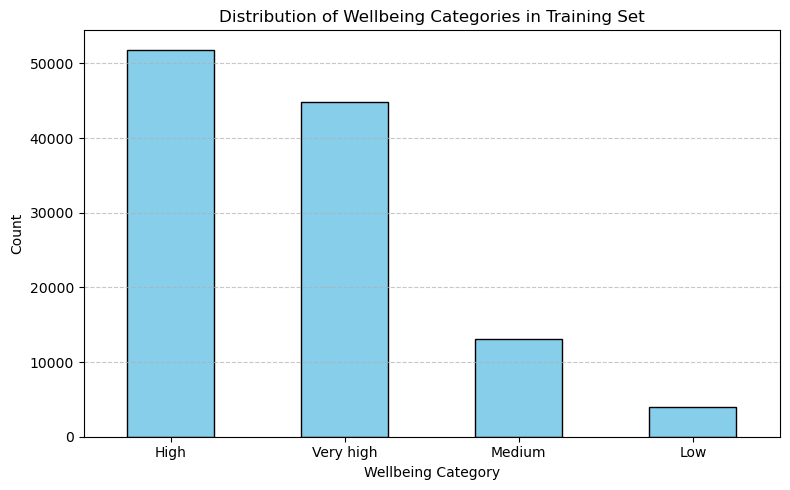

In [384]:
# Check class balance in the full dataset (after NaN drop, before split)
print(" Overall Wellbeing_category distribution (full y):")
print(y.value_counts(dropna=False))

# Check class balance in the training set
print("\n🔍 Wellbeing_category distribution in y_train:")
print(y_train.value_counts(dropna=False))

# Optional: visualize distribution in training set
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
y_train.value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.xlabel('Wellbeing Category')
plt.ylabel('Count')
plt.title('Distribution of Wellbeing Categories in Training Set')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

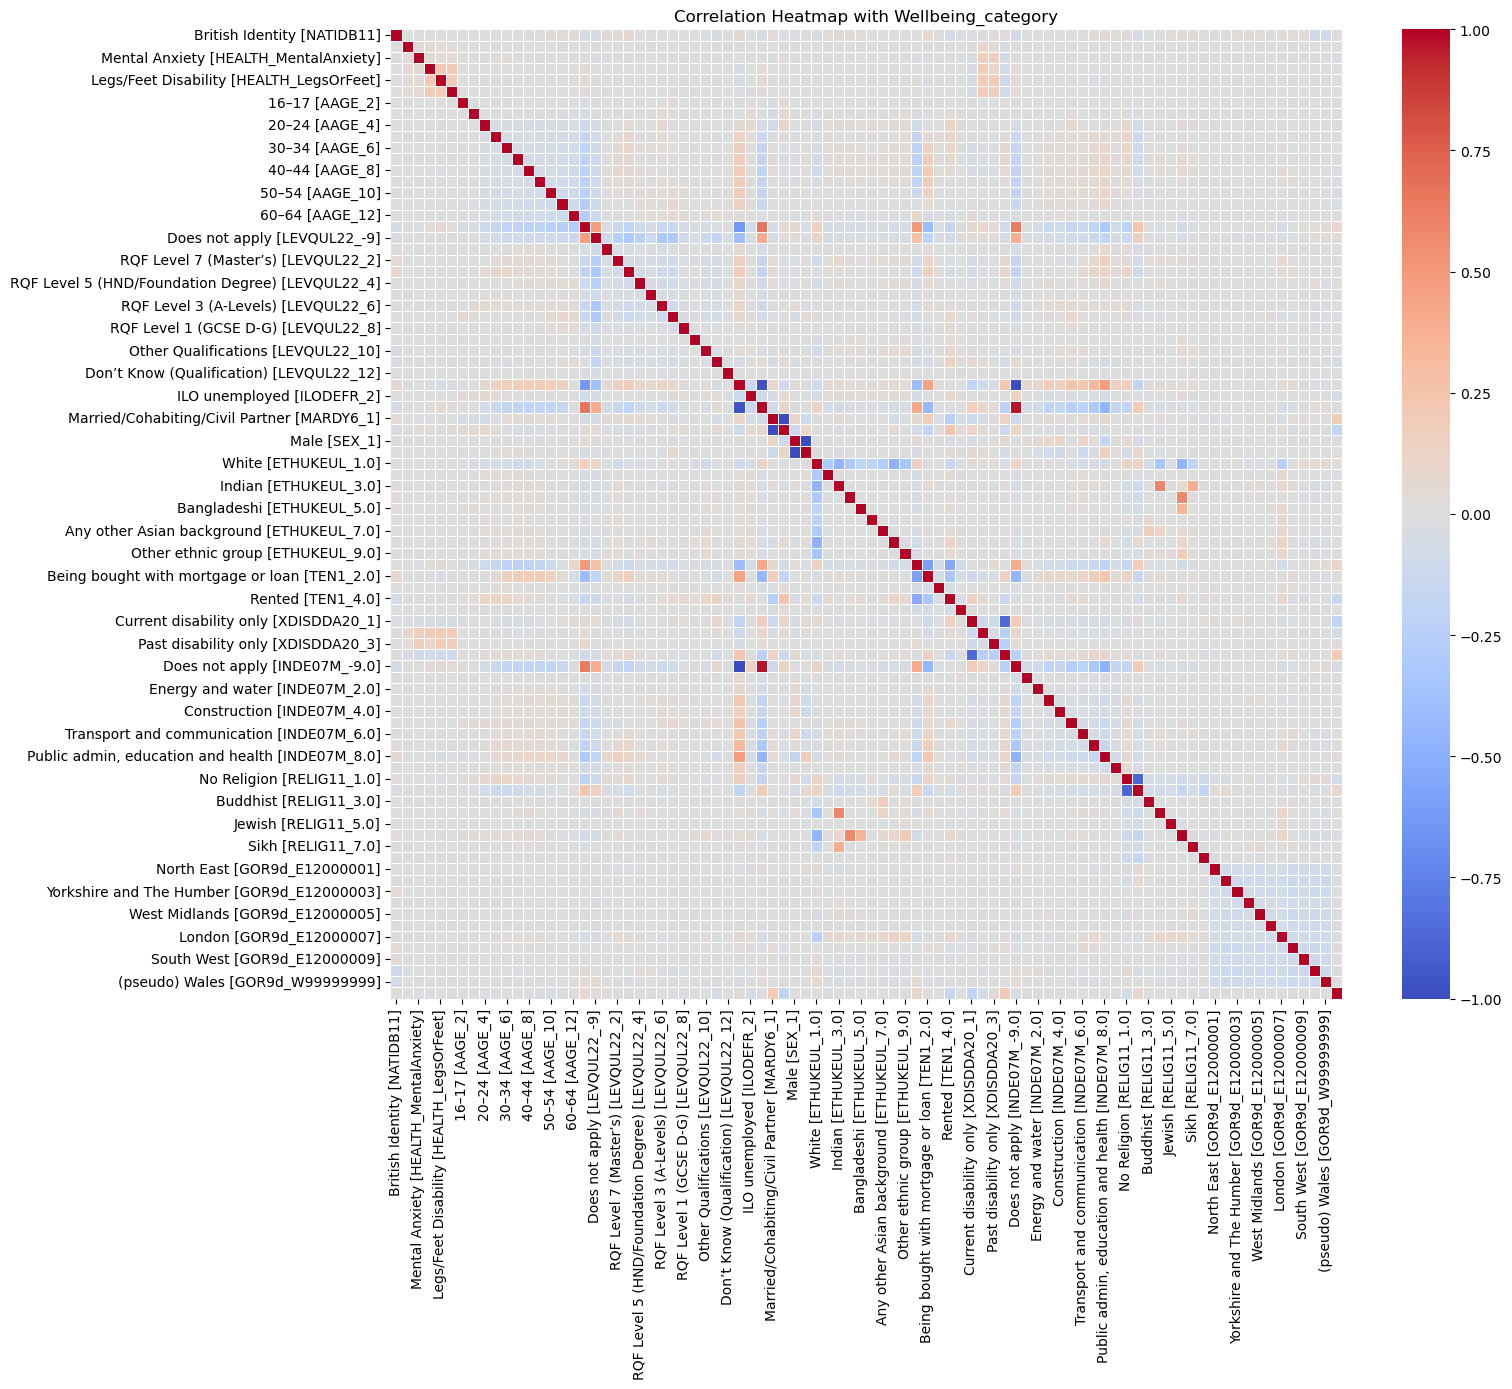

In [382]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Map Wellbeing_category to numeric
model_df['Wellbeing_category_num'] = model_df['Wellbeing_category'].map({
    'Low': 1, 
    'Medium': 2, 
    'High': 3, 
    'Very high': 4
})

# Step 2: Combine X_final (after encoding) with numeric target
corr_df = X_final.copy()
corr_df['Wellbeing_category_num'] = model_df['Wellbeing_category_num'].values

# Step 3: Compute correlation matrix
corr_matrix = corr_df.corr()

# Step 4: Apply safe renaming to rows and columns
def safe_rename(col):
    human_label = feature_labels.get(col, col)
    return f"{human_label} [{col}]"

renamed_index = [safe_rename(col) for col in corr_matrix.index]
renamed_columns = [safe_rename(col) for col in corr_matrix.columns]

corr_matrix.index = renamed_index
corr_matrix.columns = renamed_columns

# Step 5: Plot heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', linewidths=0.5, center=0)
plt.title('Correlation Heatmap with Wellbeing_category')
plt.tight_layout()
plt.show()

## **Logistic regression**

In [330]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Initialize multinomial logistic regression
logreg = LogisticRegression(
    multi_class='multinomial',
    solver='lbfgs',
    max_iter=1000,
    class_weight='balanced',
    random_state=42
)

# Step 2: Fit the model
logreg.fit(X_train, y_train)

# Step 3: Make predictions on the test set
y_pred = logreg.predict(X_test)

# Step 4: Evaluate performance
print("Classification Report (Test Set):")
print(classification_report(y_test, y_pred))

Classification Report (Test Set):
              precision    recall  f1-score   support

        High       0.54      0.31      0.39     11108
         Low       0.10      0.57      0.17       866
      Medium       0.16      0.17      0.17      2811
   Very high       0.50      0.52      0.51      9616

    accuracy                           0.39     24401
   macro avg       0.32      0.39      0.31     24401
weighted avg       0.46      0.39      0.40     24401



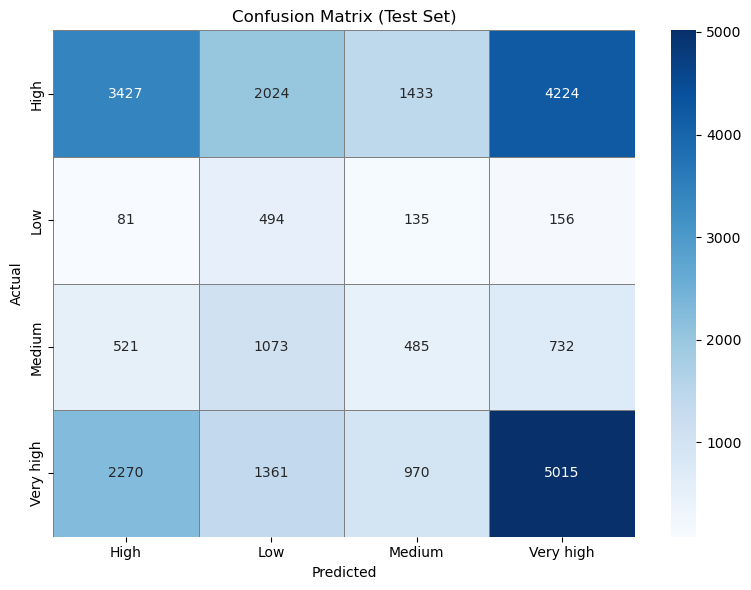

In [332]:
from sklearn.metrics import confusion_matrix

# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=logreg.classes_)

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=logreg.classes_,
            yticklabels=logreg.classes_,
            linewidths=0.5, linecolor='gray')

# Add labels and title
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Test Set)')
plt.tight_layout()
plt.show()

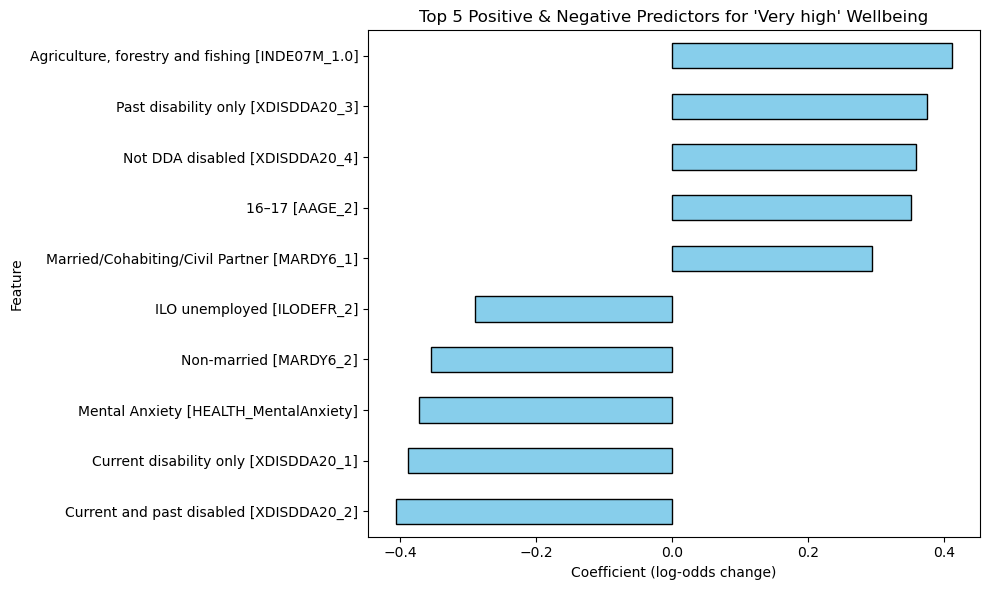

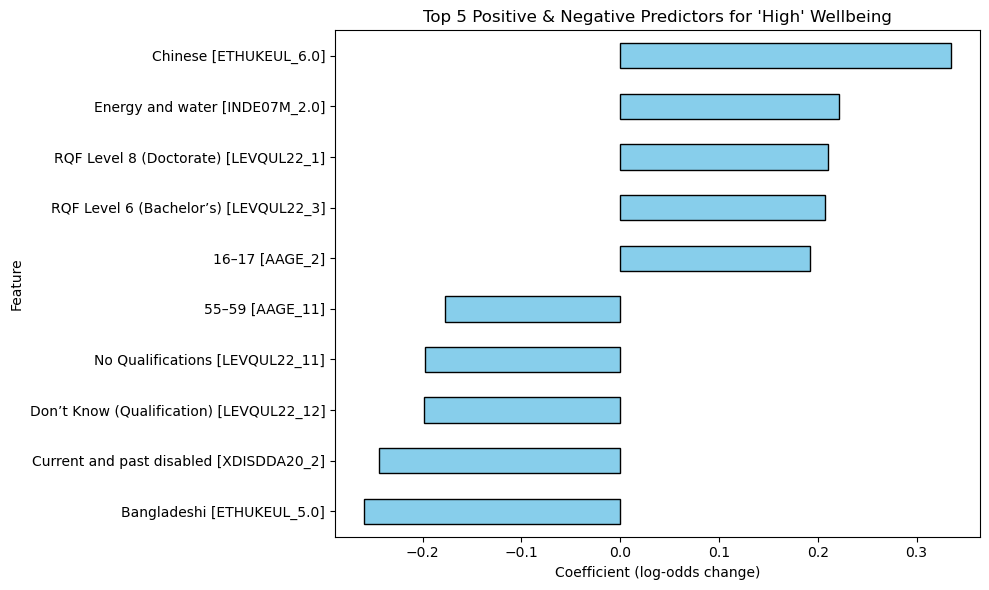

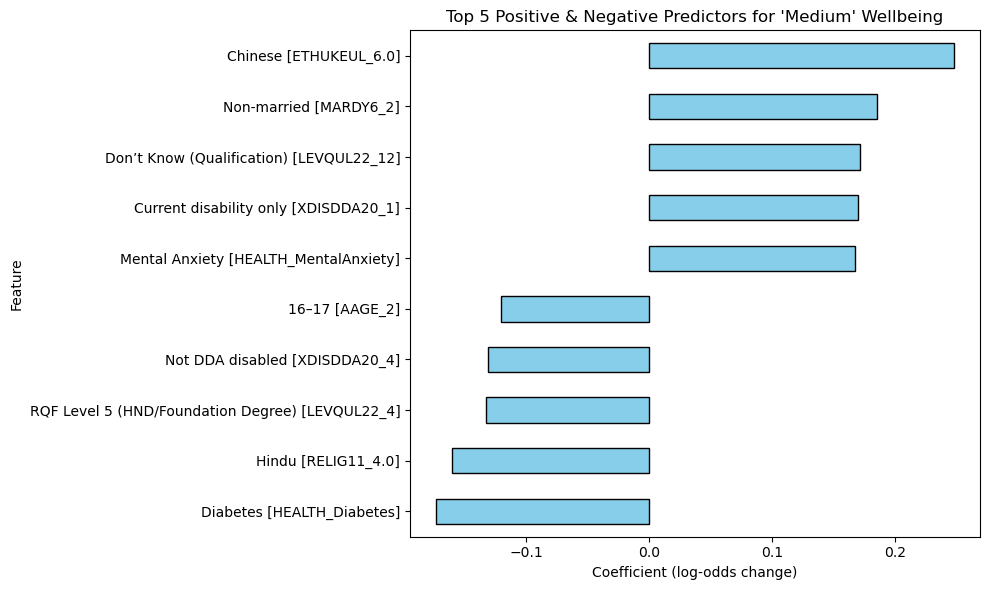

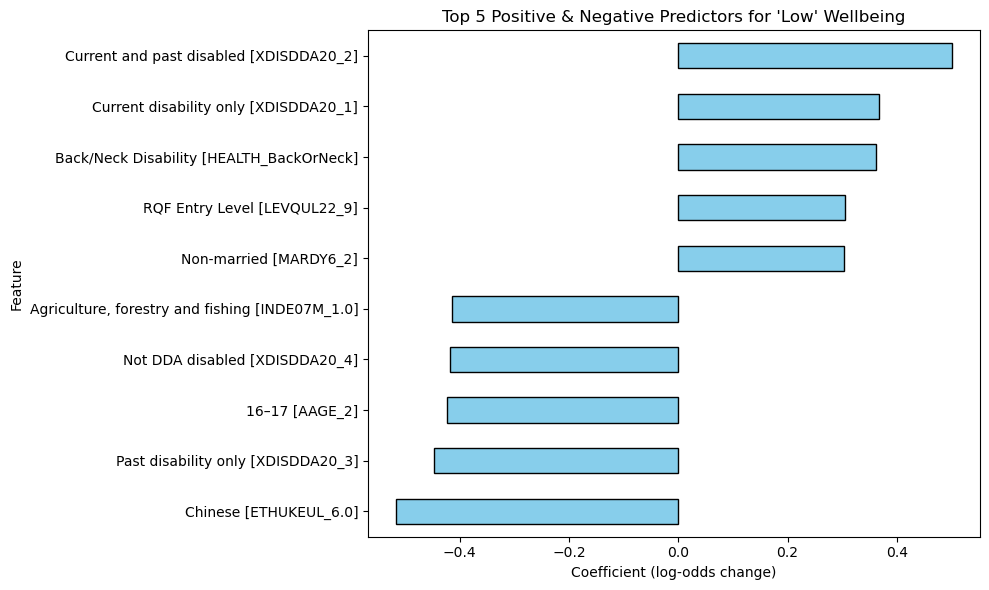

In [368]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Create coefficients DataFrame
coef_df = pd.DataFrame(
    logreg.coef_,
    columns=X_train.columns,
    index=logreg.classes_
)

# Step 2: Define order from Very high to Low
ordered_classes = ['Very high', 'High', 'Medium', 'Low']

# Step 3: For each class, plot top 5 positive & negative features
for cls in ordered_classes:
    # Get top 5 positive and top 5 negative coefficients
    top_pos = coef_df.loc[cls].sort_values(ascending=False).head(5)
    top_neg = coef_df.loc[cls].sort_values().head(5)
    top_combined = pd.concat([top_neg, top_pos])
    
    # Rename index using feature_labels dictionary, attach original code to avoid duplicates
    renamed_index = [
        f"{feature_labels.get(col, col)} [{col}]" for col in top_combined.index
    ]
    top_combined.index = renamed_index
    
    # Plot
    plt.figure(figsize=(10, 6))
    top_combined.sort_values().plot(kind='barh', color='skyblue', edgecolor='black')
    plt.title(f"Top 5 Positive & Negative Predictors for '{cls}' Wellbeing")
    plt.xlabel('Coefficient (log-odds change)')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()